In [51]:
#imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

In [52]:
#dataset

data = pd.read_csv('dataset/modern_RAPTOR_by_team.csv')

#choose season, for now latest season
data = data[data.season == 2022]
data.dropna(inplace=True)

In [53]:
#clustering features
features = ['raptor_box_offense', 'raptor_box_defense', 'raptor_onoff_offense', 'raptor_onoff_defense', 'predator_offense',
            'predator_defense', "pace_impact"]


In [54]:
#pre process data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[features])

print(data.columns)

Index(['player_name', 'player_id', 'season', 'season_type', 'team', 'poss',
       'mp', 'raptor_box_offense', 'raptor_box_defense', 'raptor_box_total',
       'raptor_onoff_offense', 'raptor_onoff_defense', 'raptor_onoff_total',
       'raptor_offense', 'raptor_defense', 'raptor_total', 'war_total',
       'war_reg_season', 'war_playoffs', 'predator_offense',
       'predator_defense', 'predator_total', 'pace_impact'],
      dtype='object')


/Users/pujithvi/miniconda3/envs/mlhw/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pujithvi/miniconda3/envs/mlhw/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pujithvi/miniconda3/envs/mlhw/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/pujithvi/miniconda3/envs/mlhw/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

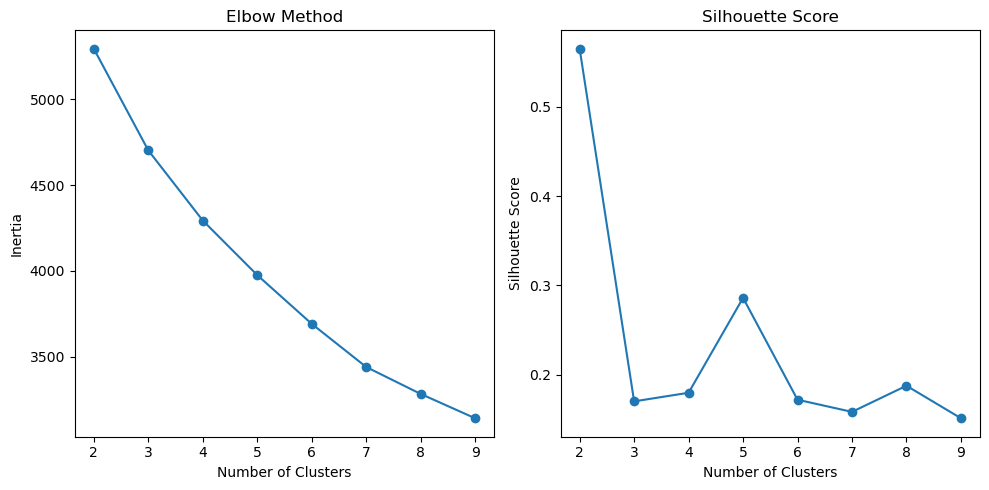

In [55]:
#define number of clusters

inertia = []
silhouette_scores = []

maxClusters = 10
minClusters = 2

# Try different numbers of clusters
for k in range(minClusters, maxClusters):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    if len(set(kmeans.labels_)) > 1:  # Silhouette score requires at least 2 clusters
        silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))
    else:
        silhouette_scores.append(None)

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(minClusters, maxClusters), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(range(minClusters, maxClusters), silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


k = 3

In [56]:
#clustering with KMeans

kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add clusters to the original dataframe
data['cluster'] = clusters

numeric_data = data.select_dtypes(include=np.number)

# Analyze clusters
cluster_stats = numeric_data.groupby('cluster').mean()



/Users/pujithvi/miniconda3/envs/mlhw/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


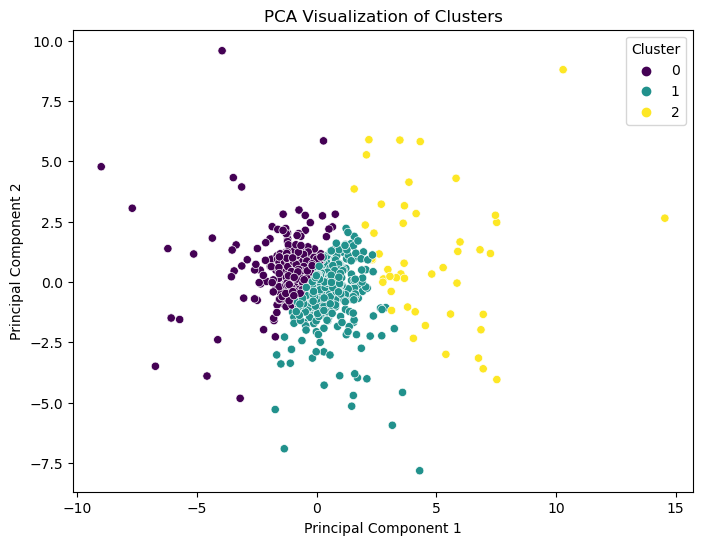

In [57]:
# Visualize clusters using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=clusters, palette='viridis')
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

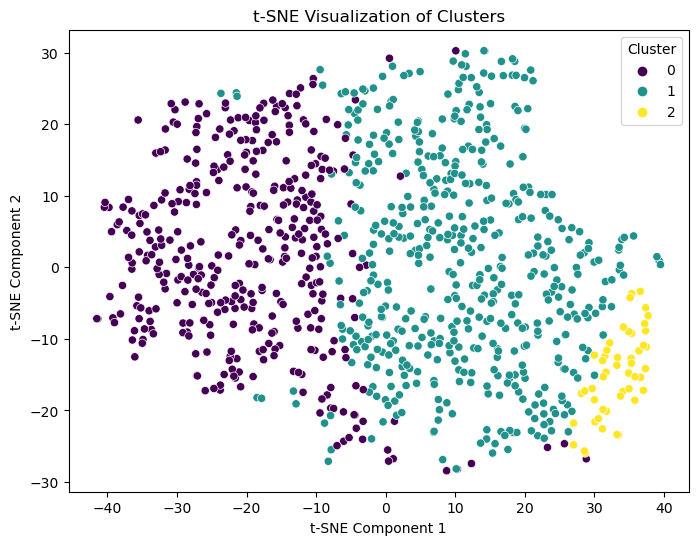

In [58]:
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(scaled_data)

# Plot t-SNE visualization with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_data[:, 0], y=tsne_data[:, 1], hue=clusters, palette='viridis', legend='full')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

In [71]:
def assign_cluster_names(cluster_stats):
    cluster_names = []
    
    # Calculate the difference between defensive and offensive RAPTOR scores for each cluster
    cluster_stats['raptor_difference'] = cluster_stats['raptor_defense'] - cluster_stats['raptor_offense']
    
    # Find the index of the cluster with the greatest difference (most defensive)
    most_defensive_cluster_idx = cluster_stats['raptor_difference'].idxmax()
    
    # Find the index of the cluster with the least difference (most offensive)
    most_offensive_cluster_idx = cluster_stats['raptor_difference'].idxmin()
    
    # Find the index of the remaining cluster
    balanced_cluster_idx = cluster_stats.index[~cluster_stats.index.isin([most_defensive_cluster_idx, most_offensive_cluster_idx])][0]
    
    # Label clusters as offensive, defensive, or balanced
    for idx in cluster_stats.index:
        if idx == most_offensive_cluster_idx:
            cluster_names.append("Offensive Powerhouses")
        elif idx == most_defensive_cluster_idx:
            cluster_names.append("Defensive Specialists")
        elif idx == balanced_cluster_idx:
            # Determine whether the balanced cluster leans towards offense or defense
            if cluster_stats.loc[idx, 'raptor_offense'] > cluster_stats.loc[idx, 'raptor_defense']:
                cluster_names.append("Balanced Players (leaning towards offense)")
            elif cluster_stats.loc[idx, 'raptor_defense'] > cluster_stats.loc[idx, 'raptor_offense']:
                cluster_names.append("Balanced Players (leaning towards defense)")
            else:
                cluster_names.append("Balanced Players (neutral)")
    return cluster_names

# def assign_cluster_names(cluster_stats):
#     cluster_names = []
#     for idx, row in cluster_stats.iterrows():
#         # Example naming criteria, adjust as needed
#         if row['raptor_defense'] > row['raptor_offense']:
#             cluster_names.append("Defensive Specialists")
#         elif row['raptor_offense'] > row['raptor_defense']:
#             cluster_names.append("Offensive Powerhouses")
#         else:
#             cluster_names.append("Balanced Players")
#     return cluster_names

In [72]:
cluster_names = assign_cluster_names(cluster_stats)

# Add cluster names to the cluster statistics dataframe
cluster_stats['cluster_name'] = cluster_names

# Print cluster statistics along with assigned names
print(cluster_stats)


         season         poss          mp  raptor_box_offense  \
cluster                                                        
0        2022.0  2006.704485  969.192612            2.035317   
1        2022.0  1106.750495  529.633663           -2.886299   
2        2022.0    34.770833   16.083333           -8.694629   

         raptor_box_defense  raptor_box_total  raptor_onoff_offense  \
cluster                                                               
0                  0.415050          2.450367              3.484883   
1                 -0.327950         -3.214249             -4.320461   
2                -13.758675        -22.453304            -20.536742   

         raptor_onoff_defense  raptor_onoff_total  raptor_offense  ...  \
cluster                                                            ...   
0                    1.555174            5.040058        2.444739  ...   
1                    0.782153           -3.538308       -3.354464  ...   
2                  -14.5269

In [73]:
def get_players_in_clusters_grouped_by_team(data):
    players_in_clusters = {}
    for cluster_label in data['cluster'].unique():
        players_in_clusters[cluster_label] = data[data['cluster'] == cluster_label].groupby('team')['player_name'].apply(list).to_dict()
    return players_in_clusters

In [74]:
# Example usage:
players_in_clusters_grouped = get_players_in_clusters_grouped_by_team(data)
for cluster_label, team_players in players_in_clusters_grouped.items():
    print(f"Cluster {cluster_label} - {cluster_stats.loc[cluster_label, 'cluster_name']}:")
    for team, players in team_players.items():
        print(f"Team: {team}, Players: {', '.join(players)}")
    print()


Cluster 1 - Defensive Specialists:
Team: ATL, Players: Cat Barber, Chaundee Brown Jr., Clint Capela, John Collins, Gorgui Dieng, Danilo Gallinari, Solomon Hill, De'Andre Hunter, De'Andre Hunter, Wes Iwundu, Jalen Johnson, Jalen Johnson, Kevin Knox II, Timothe Luwawu-Cabarrot, Timothe Luwawu-Cabarrot, Skylar Mays, Cam Reddish, Lance Stephenson, Lou Williams, Trae Young
Team: BOS, Players: Bruno Fernando, Sam Hauser, Juancho Hernangomez, Enes Freedom, Luke Kornet, Romeo Langford, Aaron Nesmith, Aaron Nesmith, Jabari Parker, Josh Richardson, Dennis Schroder, Nik Stauskas, Daniel Theis, Brodric Thomas, Derrick White, Grant Williams
Team: BRK, Players: Jevon Carter, Nic Claxton, Goran Dragic, Andre Drummond, David Duke Jr., Kevin Durant, Kessler Edwards, Kessler Edwards, Langston Galloway, Blake Griffin, Joe Harris, Shaquille Harrison, James Johnson, Paul Millsap, Cam Thomas
Team: CHA, Players: James Bouknight, Vernon Carey Jr., Gordon Hayward, Kai Jones, Jalen McDaniels, Mason Plumlee, Nic

In [63]:
def get_player_cluster(player_name, data, cluster_stats):
    # Check if the player is in the dataset
    if player_name in data['player_name'].values:
        # Get the cluster label for the player
        player_cluster = data.loc[data['player_name'] == player_name, 'cluster'].values[0]
        # Get the cluster name from cluster_stats
        cluster_name = cluster_stats.loc[player_cluster, 'cluster_name']
        return player_cluster, cluster_name
    else:
        return None, None

In [64]:
player_name = "Joel Embiid"
player_cluster, cluster_name = get_player_cluster(player_name, data, cluster_stats)
if player_cluster is not None:
    print(f"{player_name} belongs to Cluster {player_cluster} - {cluster_name}")
else:
    print(f"{player_name} not found in the dataset.")

Joel Embiid belongs to Cluster 0 - Offensive Powerhouses
